In [1]:
!pip install pykka

In [19]:
import pykka
import numpy as np

import colorsys

def rgb_conv(i):
    color = 255 * np.array(colorsys.hsv_to_rgb(i / 255.0, 1.0, 0.5))
    return tuple(color.astype(int))

def mandelbrot(x, y):
    c0 = complex(x, y)
    c = 0
    for i in range(1, 1000):
        if abs(c) > 2:
            return rgb_conv(i)
        c = c * c + c0
    return (0, 0, 0)

class Actor(pykka.ThreadingActor):
    def on_receive(self, message):
        x, y = map(int, message.split())
        return mandelbrot(x, y)

In [21]:
actor_ref = Actor.start()

answer = actor_ref.ask('0 10')
print(answer)

(127, 6, 0)


In [51]:
from PIL import Image

IMG_DIM = 1080
WINDOW = (-2, 1)
WINDOW_SIZE = WINDOW[1] - WINDOW[0]

pixels = np.zeros((IMG_DIM, IMG_DIM, 3), int)
                
x = y = np.arange(WINDOW[0], WINDOW[1], WINDOW_SIZE/IMG_DIM)
  
for i in range(IMG_DIM):
    print(i/IMG_DIM)
    for j in range(IMG_DIM):
        pixels[j][i] = mandelbrot(x[i], y[j])

0.0
0.000925925925925926
0.001851851851851852
0.002777777777777778
0.003703703703703704
0.004629629629629629
0.005555555555555556
0.006481481481481481
0.007407407407407408
0.008333333333333333
0.009259259259259259
0.010185185185185186
0.011111111111111112
0.012037037037037037
0.012962962962962963
0.013888888888888888
0.014814814814814815
0.01574074074074074
0.016666666666666666
0.017592592592592594
0.018518518518518517
0.019444444444444445
0.020370370370370372
0.021296296296296296
0.022222222222222223
0.023148148148148147
0.024074074074074074
0.025
0.025925925925925925
0.026851851851851852
0.027777777777777776
0.028703703703703703
0.02962962962962963
0.030555555555555555
0.03148148148148148
0.032407407407407406
0.03333333333333333
0.03425925925925926
0.03518518518518519
0.03611111111111111
0.037037037037037035
0.03796296296296296
0.03888888888888889
0.03981481481481482
0.040740740740740744
0.041666666666666664
0.04259259259259259
0.04351851851851852
0.044444444444444446
0.0453703703703

0.39444444444444443
0.39537037037037037
0.3962962962962963
0.3972222222222222
0.39814814814814814
0.3990740740740741
0.4
0.4009259259259259
0.40185185185185185
0.4027777777777778
0.40370370370370373
0.4046296296296296
0.40555555555555556
0.4064814814814815
0.4074074074074074
0.4083333333333333
0.40925925925925927
0.4101851851851852
0.4111111111111111
0.41203703703703703
0.412962962962963
0.41388888888888886
0.4148148148148148
0.41574074074074074
0.4166666666666667
0.41759259259259257
0.4185185185185185
0.41944444444444445
0.4203703703703704
0.4212962962962963
0.4222222222222222
0.42314814814814816
0.42407407407407405
0.425
0.42592592592592593
0.42685185185185187
0.42777777777777776
0.4287037037037037
0.42962962962962964
0.4305555555555556
0.43148148148148147
0.4324074074074074
0.43333333333333335
0.43425925925925923
0.4351851851851852
0.4361111111111111
0.43703703703703706
0.43796296296296294
0.4388888888888889
0.4398148148148148
0.44074074074074077
0.44166666666666665
0.44259259259259

0.8064814814814815
0.8074074074074075
0.8083333333333333
0.8092592592592592
0.8101851851851852
0.8111111111111111
0.812037037037037
0.812962962962963
0.8138888888888889
0.8148148148148148
0.8157407407407408
0.8166666666666667
0.8175925925925925
0.8185185185185185
0.8194444444444444
0.8203703703703704
0.8212962962962963
0.8222222222222222
0.8231481481481482
0.8240740740740741
0.825
0.825925925925926
0.8268518518518518
0.8277777777777777
0.8287037037037037
0.8296296296296296
0.8305555555555556
0.8314814814814815
0.8324074074074074
0.8333333333333334
0.8342592592592593
0.8351851851851851
0.8361111111111111
0.837037037037037
0.8379629629629629
0.8388888888888889
0.8398148148148148
0.8407407407407408
0.8416666666666667
0.8425925925925926
0.8435185185185186
0.8444444444444444
0.8453703703703703
0.8462962962962963
0.8472222222222222
0.8481481481481481
0.8490740740740741
0.85
0.850925925925926
0.8518518518518519
0.8527777777777777
0.8537037037037037
0.8546296296296296
0.8555555555555555
0.8564

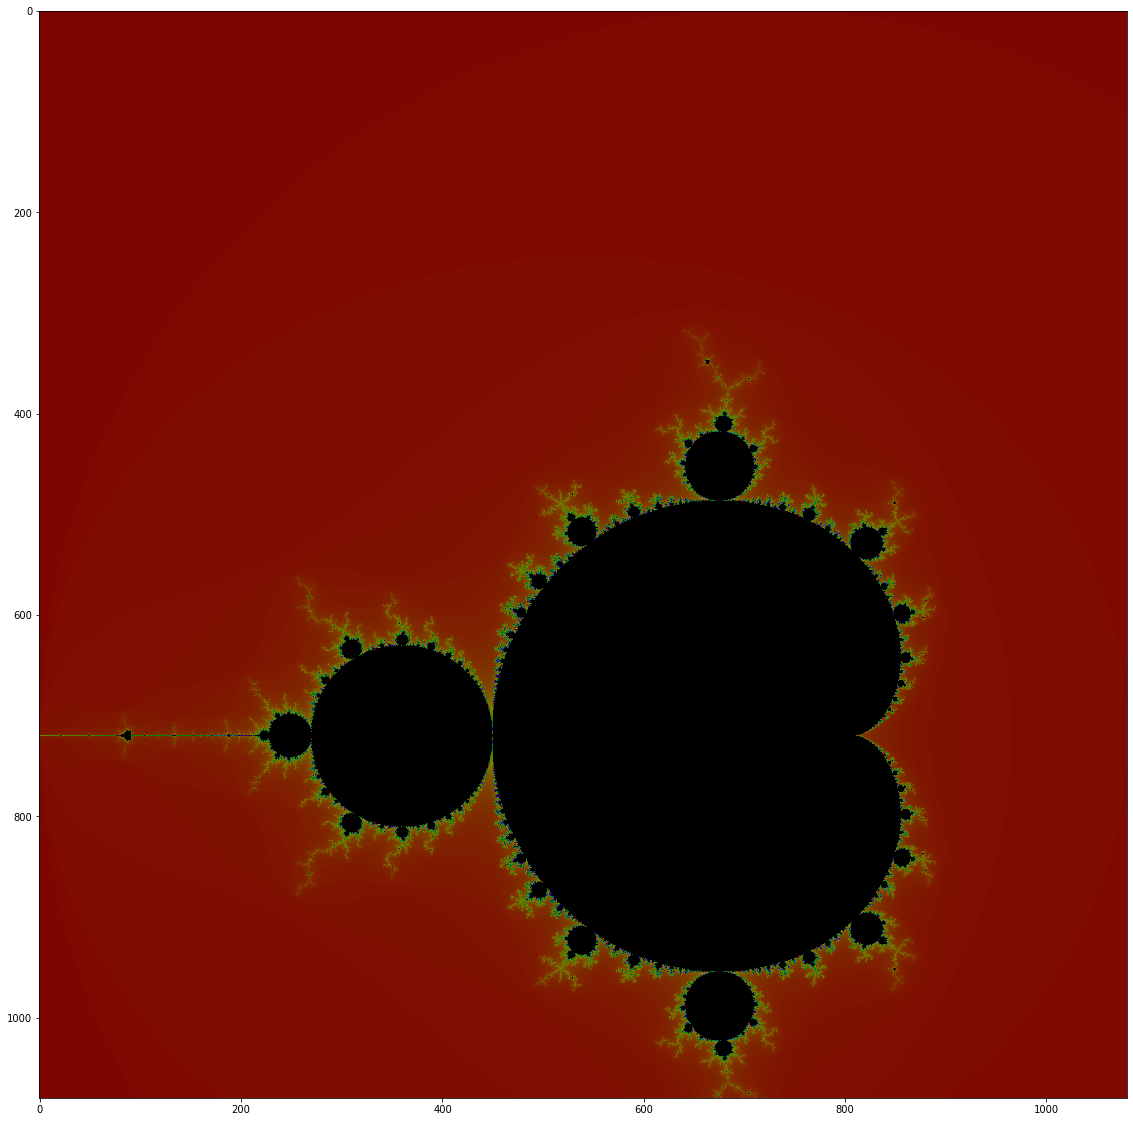

In [54]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 20))
plt.imshow(pixels, interpolation='nearest')

plt.show()